In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms 
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/cbdata/Chess ID Public Data'  # replace with the path to your data
image_datasets = {
    'train': datasets.ImageFolder(data_dir + '/output_train', data_transforms['train']),
    'test': datasets.ImageFolder(data_dir + '/output_test', data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))  # Adjust for number of chess piece classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


In [3]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    progress_bar = tqdm(dataloaders['train'], desc=f'Training Epoch {epoch+1}')
    
    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        progress_bar.set_postfix(loss=running_loss / len(image_datasets['train']),
                                 acc=running_corrects.double() / len(image_datasets['train']))
    
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects.double() / len(image_datasets['train'])
    
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test'], desc=f'Testing Epoch {epoch+1}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

    test_loss = test_loss / len(image_datasets['test'])
    test_acc = test_corrects.double() / len(image_datasets['test'])
    
    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}\n')

print('Training complete!')
model.save('chess.pt')

Epoch 1/5
----------


Training Epoch 1: 100%|██████████| 324/324 [02:19<00:00,  2.33it/s, acc=tensor(0.8429, dtype=torch.float64), loss=0.492]  


Train Loss: 0.4917 Acc: 0.8429


Testing Epoch 1: 100%|██████████| 114/114 [00:13<00:00,  8.73it/s]


Test Loss: 0.0184 Test Acc: 0.9964

Epoch 2/5
----------


Training Epoch 2: 100%|██████████| 324/324 [02:21<00:00,  2.29it/s, acc=tensor(0.9251, dtype=torch.float64), loss=0.231] 


Train Loss: 0.2315 Acc: 0.9251


Testing Epoch 2: 100%|██████████| 114/114 [00:15<00:00,  7.60it/s]


Test Loss: 0.0182 Test Acc: 0.9951

Epoch 3/5
----------


Training Epoch 3: 100%|██████████| 324/324 [02:21<00:00,  2.29it/s, acc=tensor(0.9403, dtype=torch.float64), loss=0.184] 


Train Loss: 0.1838 Acc: 0.9403


Testing Epoch 3: 100%|██████████| 114/114 [00:14<00:00,  7.64it/s]


Test Loss: 0.0065 Test Acc: 0.9984

Epoch 4/5
----------


Training Epoch 4: 100%|██████████| 324/324 [02:23<00:00,  2.26it/s, acc=tensor(0.9466, dtype=torch.float64), loss=0.165] 


Train Loss: 0.1649 Acc: 0.9466


Testing Epoch 4: 100%|██████████| 114/114 [00:13<00:00,  8.43it/s]


Test Loss: 0.0046 Test Acc: 0.9989

Epoch 5/5
----------


Training Epoch 5: 100%|██████████| 324/324 [02:22<00:00,  2.27it/s, acc=tensor(0.9536, dtype=torch.float64), loss=0.144] 


Train Loss: 0.1441 Acc: 0.9536


Testing Epoch 5: 100%|██████████| 114/114 [00:15<00:00,  7.46it/s]


Test Loss: 0.0069 Test Acc: 0.9978

Training complete!


AttributeError: 'ResNet' object has no attribute 'save'

In [4]:
torch.save(model.state_dict(), 'chess.pt')

In [11]:
from PIL import Image
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Resize the image to match the model input size
    image = image.resize((224, 224))
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension



In [8]:
# Predict the pieces in each square using the trained model
def predict_board(image, model):
    model.eval()
    board_predictions = []
    
    # Assuming the input image is a full chessboard
    grid_size = 8
    square_size = image.size[0] // grid_size
    
    for row in range(grid_size):
        row_predictions = []
        for col in range(grid_size):
            # Extract the square image (crop)
            square_image = image.crop((col * square_size, row * square_size, 
                                       (col + 1) * square_size, (row + 1) * square_size))
            # Preprocess the square
            square_tensor = preprocess_image(square_image)
            square_tensor = square_tensor.to(device)

            # Predict the class
            with torch.no_grad():
                outputs = model(square_tensor)
                _, predicted_class = torch.max(outputs, 1)
            
            row_predictions.append(predicted_class.item())  # Store the predicted class index
        board_predictions.append(row_predictions)

    return board_predictions


In [9]:
# Map predicted class indices to chess piece symbols
def display_digital_board(board_predictions, class_names):
    board = np.full((8, 8), '-', dtype='<U2')  # Create an empty 8x8 board filled with '-'
    
    # Replace '-' with the predicted chess pieces
    for row in range(8):
        for col in range(8):
            piece = class_names[board_predictions[row][col]]
            board[row][col] = piece
    
    print("Detected Chessboard:")
    print(board)

    # Plot the board visually
    fig, ax = plt.subplots()
    ax.imshow(np.zeros((8, 8)), cmap='gray')  # Just a blank chessboard for now
    
    # Add text annotations for pieces
    for i in range(8):
        for j in range(8):
            piece = board[i, j]
            ax.text(j, i, piece, ha="center", va="center", color="white", fontsize=20)

    plt.show()


/tmp/ipykernel_13/2733242164.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('chess.pt'))


Detected Chessboard:
[['bn' 'em' 'em' 'br' 'wn' 'em' 'em' 'bb']
 ['br' 'wq' 'wn' 'bk' 'bk' 'bk' 'wn' 'em']
 ['bq' 'bq' 'bq' 'bk' 'bk' 'bk' 'wq' 'wb']
 ['bq' 'bk' 'bq' 'bn' 'bk' 'bk' 'bk' 'bk']
 ['bq' 'bq' 'bk' 'bq' 'bq' 'bk' 'bn' 'bn']
 ['em' 'bq' 'bn' 'bq' 'bk' 'bn' 'bn' 'bn']
 ['em' 'em' 'bq' 'bq' 'bk' 'bq' 'em' 'bn']
 ['wb' 'wb' 'em' 'bk' 'bn' 'bb' 'bn' 'bn']]


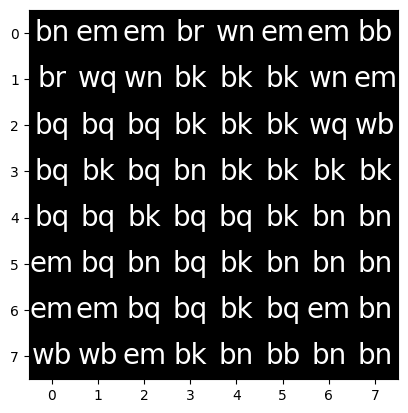

In [17]:
# Full pipeline to detect and display chess pieces
image_path = '/kaggle/input/boardd/Board.jpg'  # Replace with your chessboard image path

# Load the model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))  # Adjust for number of chess pieces
model.load_state_dict(torch.load('chess.pt'))
model = model.to(device)

# Class names for chess pieces, example:
class_names = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']  # Adjust based on your dataset

# Open image
image = Image.open(image_path)

# Predict board configuration
board_predictions = predict_board(image, model)

# Display digital chessboard
display_digital_board(board_predictions, class_names)
